# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.



In [40]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots # for determining (p,q) orders
from pmdarima.arima import auto_arima # for determining ARIMA orders

In [2]:
df1 = pd.read_csv('../03_Forecasting_Models/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('../03_Forecasting_Models/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

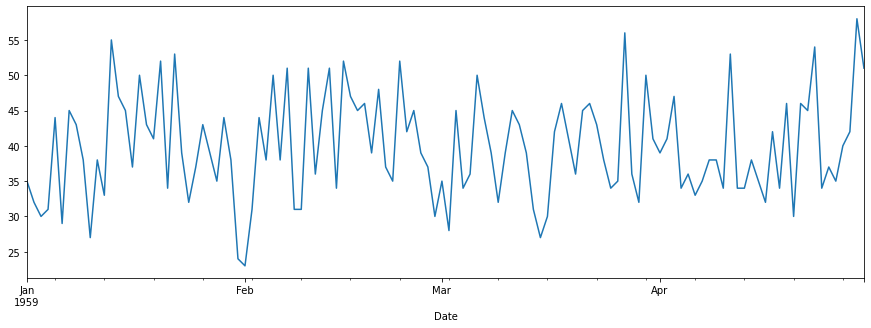

In [4]:
df1['Births'].plot(figsize=(15,5));

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [6]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [41]:
auto_arima(df1['Births'], d=0, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Thu, 03 Mar 2022   AIC                            823.489
Time:                        18:01:22   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.36   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [24]:
# Set one month for testing

train = df1.iloc[:90]
test = df1.iloc[90:]

In [15]:
model = ARIMA(train['Births'], order=(2,0,2))

This model is the basic interface for ARIMA-type models, including those
with exogenous regressors and those with seasonal components. The most
general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows
all specialized cases, including

- autoregressive models: AR(p)
- moving average models: MA(q)
- mixed autoregressive moving average models: ARMA(p, q)
- integration models: ARIMA(p, d, q)
- seasonal models: SARIMA(P, D, Q, s)
- regression with errors that follow one of the above ARIMA-type models

#### Parameters
----------
**endog :** array_like, optional
    The observed time-series process :math:`y`.
    
**exog :** array_like, optional
    Array of exogenous regressors.
    
**order :** tuple, optional
    The (p,d,q) order of the model for the autoregressive, differences, and
    moving average components. d is always an integer, while p and q may
    either be integers or lists of integers.
    
**seasonal_order :** tuple, optional
    The (P,D,Q,s) order of the seasonal component of the model for the
    AR parameters, differences, MA parameters, and periodicity. Default
    is (0, 0, 0, 0). D and s are always integers, while P and Q
    may either be integers or lists of positive integers.
    
**trend :** str{'n','c','t','ct'} or iterable, optional
    Parameter controlling the deterministic trend. Can be specified as a
    string where 'c' indicates a constant term, 't' indicates a
    linear trend in time, and 'ct' includes both. Can also be specified as
    an iterable defining a polynomial, as in `numpy.poly1d`, where
    `[1,1,0,1]` would denote :math:`a + bt + ct^3`. Default is 'c' for
    models without integration, and no trend for models with integration.
    Note that all trend terms are included in the model as exogenous
    regressors, which differs from how trends are included in ``SARIMAX``
    models.  See the Notes section for a precise definition of the
    treatment of trend terms.

**missing :** str
    Available options are 'none', 'drop', and 'raise'. If 'none', no nan
    checking is done. If 'drop', any observations with nans are dropped.
    If 'raise', an error is raised. Default is 'none'.

In [16]:
results = model.fit()

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -307.812
Date:                Thu, 03 Mar 2022   AIC                            627.625
Time:                        17:49:56   BIC                            642.624
Sample:                    01-01-1959   HQIC                           633.673
                         - 03-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7571      1.017     39.096      0.000      37.764      41.750
ar.L1         -0.4670      1.005     -0.465      0.642      -2.437       1.503
ar.L2          0.5071      0.942      0.538      0.590      -1.339       2.353
ma.L1          0.5631     13.679      0.041      0.967     -26.247      27.374
ma.L2         -0.4368      5.880     -0.074      0.941     -11.961      11.088
sigma2        54.3770    726.827      0.075      0.940   -1370.177    1478.931
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.96   Prob(JB):                         0.37
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Obtain a month's worth of predicted values

In [25]:
start = len(train)
end = len(train) + len(test) - 1

In [26]:
preds = results.predict(start,end).rename('ARMA (2,0,2) Predictions')

In [27]:
preds

1959-04-01    40.533560
1959-04-02    39.549613
1959-04-03    40.247735
1959-04-04    39.422777
1959-04-05    40.162043
1959-04-06    39.398485
1959-04-07    40.129938
1959-04-08    39.401162
1959-04-09    40.112409
1959-04-10    39.410706
1959-04-11    40.099063
1959-04-12    39.421779
1959-04-13    40.087125
1959-04-14    39.432968
1959-04-15    40.075846
1959-04-16    39.443910
1959-04-17    40.065017
1959-04-18    39.454515
1959-04-19    40.054573
1959-04-20    39.464770
1959-04-21    40.044487
1959-04-22    39.474680
1959-04-23    40.034745
1959-04-24    39.484255
1959-04-25    40.025334
1959-04-26    39.493505
1959-04-27    40.016242
1959-04-28    39.502442
1959-04-29    40.007458
1959-04-30    39.511076
Freq: D, Name: ARMA (2,0,2) Predictions, dtype: float64

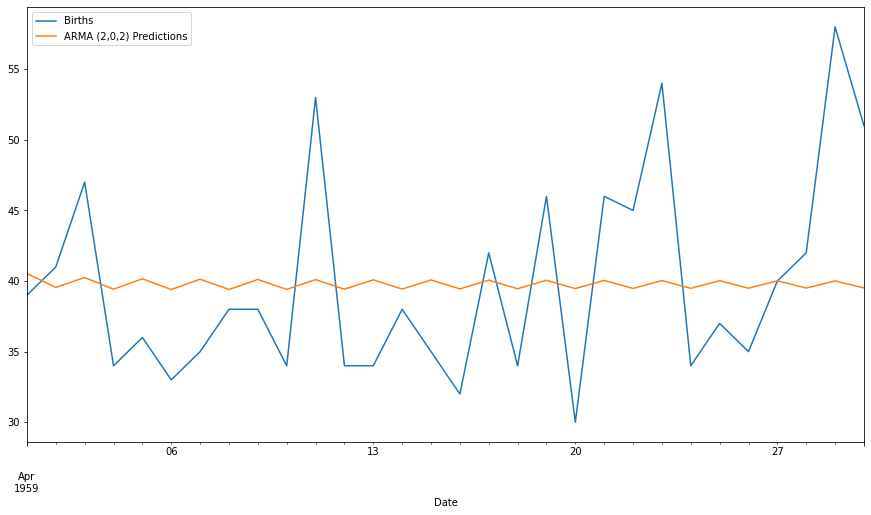

In [30]:
test['Births'].plot(figsize=(15,8), legend=True)
preds.plot(legend=True);

In [31]:
test.mean()

Births    39.833333
dtype: float64

In [32]:
preds.mean()

39.78540732214209

___
## Autoregressive Integrated Moving Average - ARIMA(p,d,q)
The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.<br>

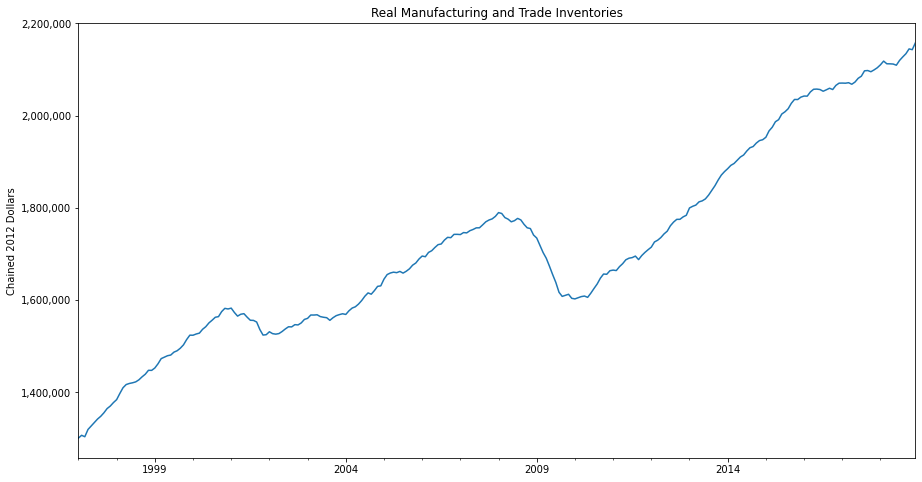

In [33]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(15,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Run an ETS Decomposition (optional)

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

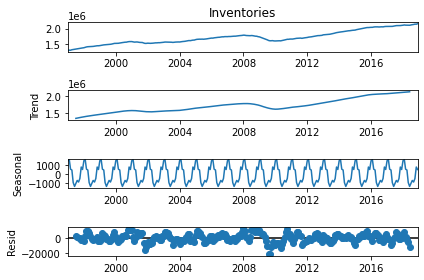

In [36]:
seasonal_decompose(df2['Inventories'], model='add').plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.
### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [42]:
auto_arima(df2['Inventories'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Thu, 03 Mar 2022   AIC                           5348.037
Time:                        18:02:22   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the First Difference

In [43]:
from statsmodels.tsa.statespace.tools import diff

In [44]:
df2['Diff_1'] = diff(df2['Inventories'], k_diff=1) 

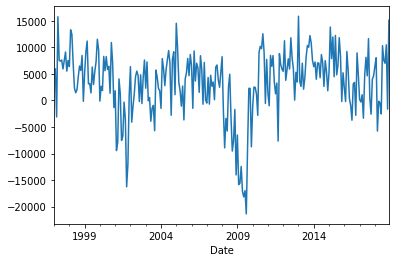

In [51]:
df2['Diff_1'].plot();

In [45]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference.
### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

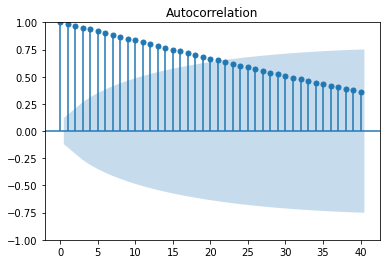

In [47]:
tsaplots.plot_acf(df2['Inventories'], lags=40);

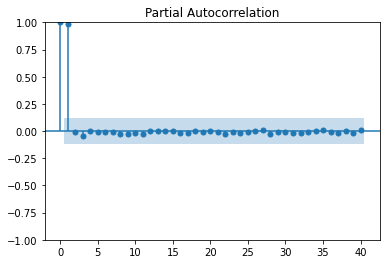

In [48]:
tsaplots.plot_pacf(df2['Inventories'], lags=40);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

In [ ]:
# AR = 1
# I = 1
# MA = 0 or 1 # less error

In [54]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0, max_p=3, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.177 seconds


### Split the data into train/test sets

In [55]:
len(df2)

264

In [57]:
train = df2.iloc[:252]
test = df2.iloc[252:]

### Fit an ARIMA(1,1,1) Model

In [60]:
model = ARIMA(train['Inventories'], order = (1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2552.901
Date:                Thu, 03 Mar 2022   AIC                           5111.801
Time:                        18:56:07   BIC                           5122.377
Sample:                    01-01-1997   HQIC                          5116.057
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    579.980      0.000       0.997       1.003
ma.L1         -0.9998      0.019    -51.601      0.000      -1.038      -0.962
sigma2      3.247e+07   1.54e-11   2.11e+18      0.000    3.25e+07    3.25e+07
===================================================================================
Ljung-Box (L1) (Q):                  87.24   Jarque-Bera (JB):               100.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -1.18
Prob(H) (two-sided):                  0.27   Kurtosis:                         5.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.8e+34. Standard errors may be unstable.
"""

In [61]:
start = len(train)
end = len(train) + len(test) - 1

preds = results.predict(start=start, end=end).rename('ARIMA (1,1,1) Predictions')

In [62]:
preds

2018-01-01    2.106715e+06
2018-02-01    2.109678e+06
2018-03-01    2.112642e+06
2018-04-01    2.115605e+06
2018-05-01    2.118569e+06
2018-06-01    2.121532e+06
2018-07-01    2.124496e+06
2018-08-01    2.127459e+06
2018-09-01    2.130422e+06
2018-10-01    2.133386e+06
2018-11-01    2.136349e+06
2018-12-01    2.139312e+06
Freq: MS, Name: ARIMA (1,1,1) Predictions, dtype: float64

In [63]:
test

,Inventories,Diff_1
Date,,
2018-01-01,2110158,6407.0
2018-02-01,2118199,8041.0
2018-03-01,2112427,-5772.0
2018-04-01,2112276,-151.0
2018-05-01,2111835,-441.0
2018-06-01,2109298,-2537.0
2018-07-01,2119618,10320.0
2018-08-01,2127170,7552.0
2018-09-01,2134172,7002.0


<AxesSubplot:xlabel='Date'>

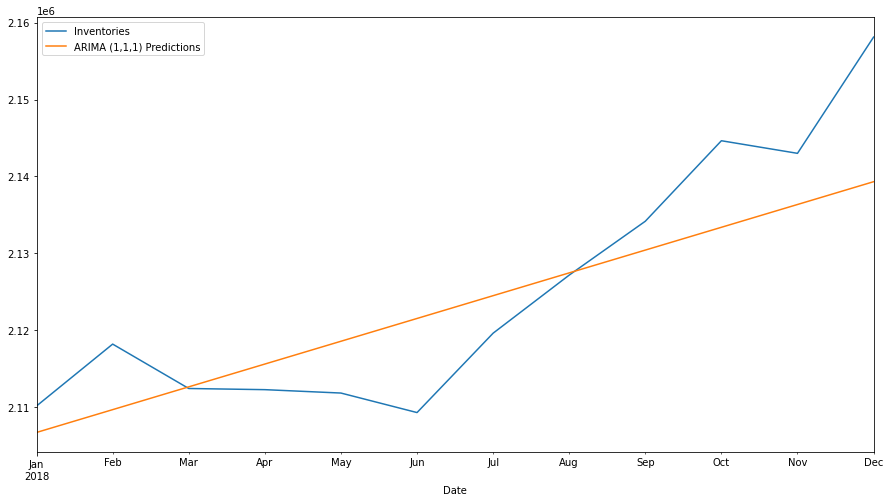

In [64]:
test['Inventories'].plot(figsize=(15,8), legend=True)
preds.plot(legend=True)

### Evaluate the Model

In [65]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], preds)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 8430.960116


In [66]:
preds.mean()

2123013.652668784

In [67]:
test['Inventories'].mean()

2125075.6666666665

### Retrain the model on the full data, and forecast the future

In [69]:
model = ARIMA(df2['Inventories'], order=(1,1,1))

In [70]:
results = model.fit()

In [71]:
forecast = results.predict(start=len(df2), end=len(df2)+11).rename('ARIMA (1,1,1) Forecast')

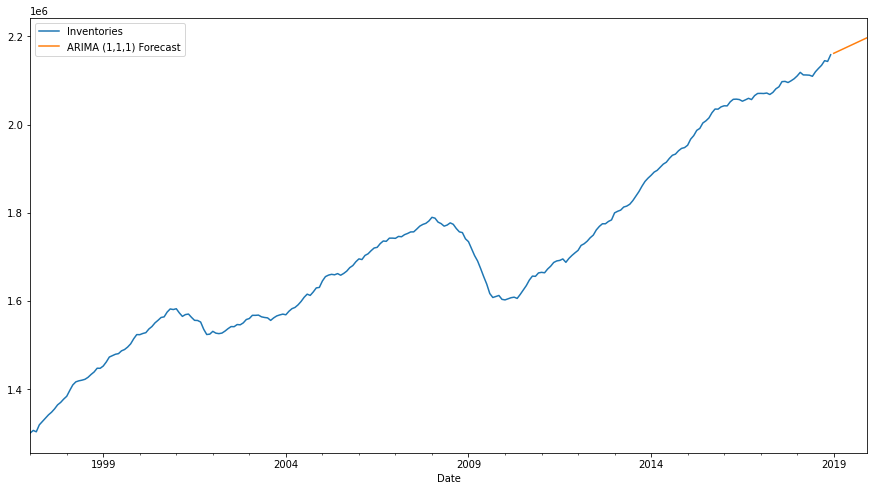

In [73]:
df2['Inventories'].plot(figsize=(15,8), legend=True)
forecast.plot(legend=True);